## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Criando o cenario

In [54]:
num_of_samples = 1000000

transaction_amount = np.minimum(np.random.lognormal(4.0, 1.4, num_of_samples), num_of_samples)
international_purchase = np.random.binomial(5, 1.0 * transaction_amount / np.linalg.norm(transaction_amount),
                                            num_of_samples)

In [55]:
international_purchase.mean()

0.001916

In [56]:
target = (np.random.standard_cauchy(num_of_samples) 
          * transaction_amount
          * np.where(international_purchase, 0.4, 0.1))

target = np.where(target > np.quantile(target, 0.97), 1, 0)

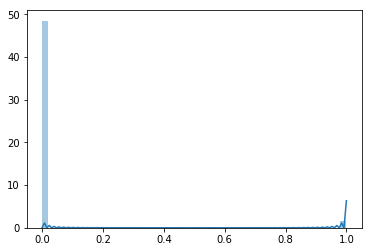

In [57]:
sns.distplot(target)

In [58]:
scores = np.where(target, 
                  np.maximum(np.minimum(np.random.normal(0.6, 0.5, num_of_samples), 1.0), 0.0),
                  np.maximum(np.minimum(np.random.normal(0.2, 0.3, num_of_samples), 1.0), 0.0))  

In [59]:
df = pd.DataFrame(
    {"amount": transaction_amount,
     "international_purchase": international_purchase,
     "is_fraud": target,
      "score": scores}
)

df.head()

,amount,international_purchase,is_fraud,score
0,291.899285,0,0,0.264879
1,29.372090,0,0,0.183100
2,153.462670,0,0,0.117238
3,471.391548,0,0,0.163781
4,17.260943,0,0,0.312624


In [60]:
np.mean(transaction_amount)

145.48616921102774

In [61]:
df.shape

(1000000, 4)

In [62]:
review_fraud_cost = 8.0
new_card_cost = 4.0
interchange_revenue = 0.015
target_col = "is_fraud"
prediction_col = "score"
amount_col = "amount"
blocked_col = "blocked"

In [63]:
df[target_col].value_counts()

0    970000
1     30000
Name: is_fraud, dtype: int64

In [64]:
df[amount_col].mean()

145.48616921102774

In [65]:
df[target_col].mean()

0.03

In [66]:
df.isnull().sum()

amount                    0
international_purchase    0
is_fraud                  0
score                     0
dtype: int64

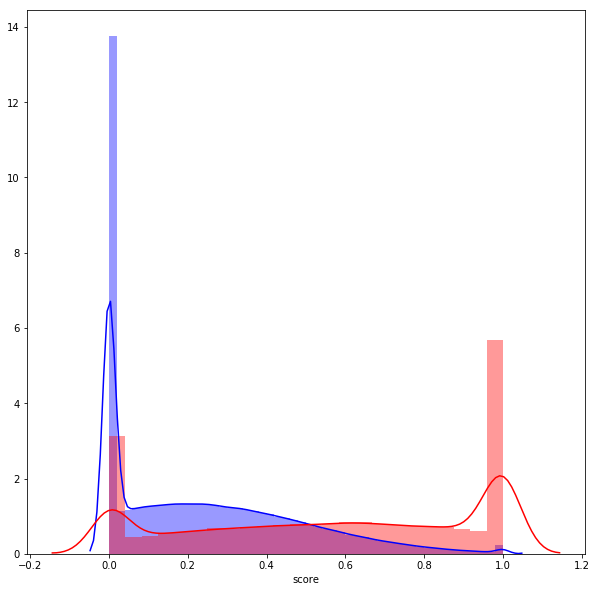

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.distplot(df.loc[lambda df: df[target_col] == 0][prediction_col], ax=ax, color="b")
sns.distplot(df.loc[lambda df: df[target_col] == 1][prediction_col], ax=ax, color="r")

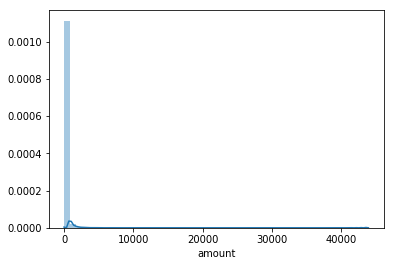

In [68]:
sns.distplot(df[amount_col])

## Metricas basicas recap
Como temos um problema de classificação, vamos focar nas metricas basicas de classificação AUC, Logloss, Matriz de Confusão

In [69]:
from sklearn.metrics import auc, log_loss, roc_curve, confusion_matrix, precision_recall_curve

In [70]:
fpr, tpr, thresholds = roc_curve(df[target_col], df[prediction_col])
auc(fpr, tpr)

0.7564077153951889

In [71]:
precision, recall, thresholds = precision_recall_curve(df[target_col], df[prediction_col])
auc(recall, precision)

0.2997721597762371

In [72]:
log_loss(df[target_col], df[prediction_col])

0.5972021410718599

In [73]:
threshold = 0.1 # definindo um threshold arbitrario pra gerar a matrix de confusao
# o estudo de thresholds vira na sequencia
cf_matrix = confusion_matrix(df[target_col], df[prediction_col] > threshold)
cf_matrix


array([[359341, 610659],
       [  4715,  25285]])

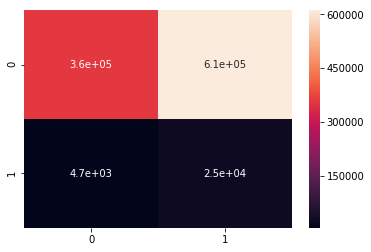

In [74]:
sns.heatmap(cf_matrix, annot=True)

## Validação na vida real

Como mencionado nos slides, se dois grupos diferentes tem comportamentos diferentes ou impactam o negócio de maneira distinta, é fundamental avaliar a performance de ambos separadamente

In [75]:
national_df = df.loc[df.international_purchase == 0]
fpr_national, tpr_national, thresholds_national = roc_curve(national_df[target_col], national_df[prediction_col])
auc(fpr_national, tpr_national)

0.7561900990430066

In [77]:
international_df = df.loc[df.international_purchase == 1]
fpr_international, tpr_international, thresholds_international = roc_curve(international_df[target_col], international_df[prediction_col])
auc(fpr_international, tpr_international)

0.7718410314590902

## Definindo um threshold
Aqui desejamos achar um corte que maximize a nossa lucrativade

Primeiro, vamos definir uma função pra calcular o custo de um conjunto de decisões

Depois, podemos gerar todos os thresholds possiveis e qual seria o label de cada transação nesse caso

In [78]:
def profit_from_decision(decision_df):
    # decision_df must have a column `is_fraud` indicating the decision
    # target represents the true information if that transaction was a fraud or not
    # transaction_amount is used to calculate revenues and costs
    return decision_df.assign(
     operational_cost = lambda df: (df[target_col] | df[blocked_col]) * review_fraud_cost,
     card_cost = lambda df: np.where((~df[blocked_col]) & (df[target_col]), new_card_cost, 0),
     fraud_losses = lambda df: ((~df[blocked_col]) & (df[target_col])) * df[amount_col],
     revenues = lambda df: ((~df[blocked_col]) & (~df[target_col])) * df[amount_col] * interchange_revenue,
     profit = lambda df: df.revenues - (df.fraud_losses + df.operational_cost + df.card_cost)
    )[["operational_cost", "card_cost", "fraud_losses", "revenues", "profit"]].sum()

In [79]:
possible_thresholds = np.arange(0.001, 1.0, 0.05)
all_decisions = []
for threshold in possible_thresholds: 
    all_decisions.append(profit_from_decision(df.assign(blocked=lambda df: df[prediction_col] >= threshold)))
    

threshold_evaluation = pd.concat(all_decisions, axis=1, keys=[s for s in possible_thresholds]).T.rename_axis("threshold").reset_index()

threshold_evaluation.head(5)

,threshold,operational_cost,card_cost,fraud_losses,revenues,profit
0,0.001,6027608.0,13672.0,2.212524e+06,477088.261711,-7.776716e+06
1,0.051,5589464.0,16092.0,2.602805e+06,582923.577678,-7.625437e+06
2,0.101,5115408.0,18916.0,3.084597e+06,697970.766288,-7.520950e+06
3,0.151,4616776.0,21952.0,3.574147e+06,819997.795974,-7.392877e+06
4,0.201,4103032.0,25480.0,4.140294e+06,945804.057566,-7.323002e+06


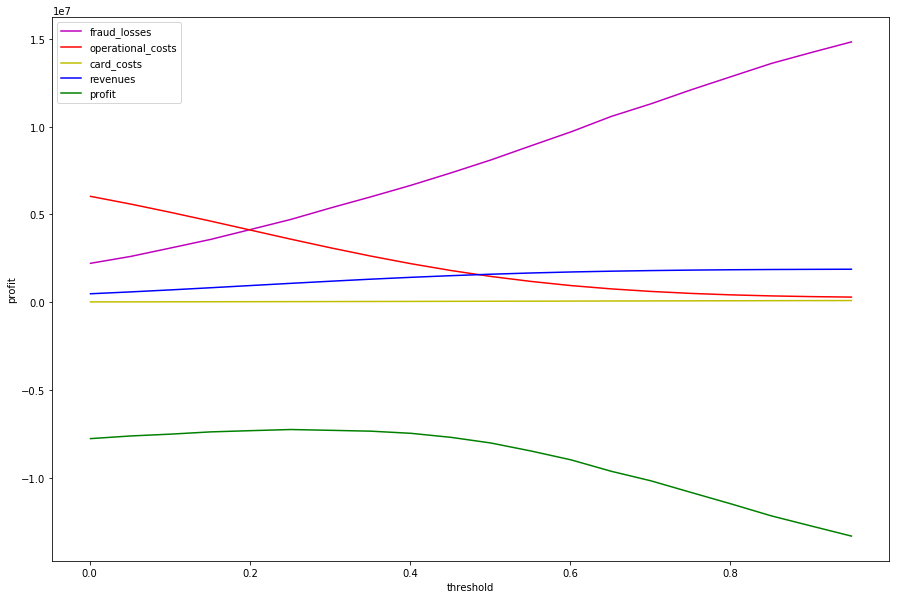

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.fraud_losses, color="m")
sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.operational_cost, color="r")
sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.card_cost, color="y")
sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.revenues, color="b")
sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.profit, color="g")

ax.legend(["fraud_losses", "operational_costs", "card_costs", "revenues", "profit"])
# plt.title("Costs (g), Revenues (b), Profit (r)")

In [82]:
best_decision = threshold_evaluation.loc[lambda df: df["profit"].idxmax()]
best_decision

threshold           2.510000e-01
operational_cost    3.588960e+06
card_cost           2.900800e+04
fraud_losses        4.710877e+06
revenues            1.070782e+06
profit             -7.258064e+06
Name: 5, dtype: float64

In [84]:
threshold_df = df.assign(blocked=lambda df: df[prediction_col] >= best_decision.threshold)
threshold_df

,amount,international_purchase,is_fraud,score,blocked
0,291.899285,0,0,0.264879,True
1,29.372090,0,0,0.183100,False
2,153.462670,0,0,0.117238,False
3,471.391548,0,0,0.163781,False
4,17.260943,0,0,0.312624,True
5,38.895820,0,0,0.291718,True
6,62.400743,0,0,0.187849,False
7,2.941405,0,0,0.000000,False
8,58.097295,0,0,0.474347,True
9,375.249275,0,1,0.000000,False


## Calibrando um modelo

Para construção de um modelo de negócio que utilize as probabilidades, é fundamental que essas probabilidades estejam calibradas com o target

### Calibração

In [85]:
from fklearn.training.calibration import isotonic_calibration_learner
from sklearn.calibration import calibration_curve
isotonic_calibration_fn, transformed_df, logs = isotonic_calibration_learner(df,
                                                                             target_column=target_col,
                                                                            prediction_column=prediction_col)

(array([9.43963e+05, 3.01730e+04, 1.04290e+04, 2.21500e+03, 2.67300e+03,
        5.69000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 9.97800e+03]),
 array([0.01277539, 0.07507773, 0.13738007, 0.1996824 , 0.26198474,
        0.32428707, 0.38658941, 0.44889175, 0.51119408, 0.57349642,
        0.63579876]),
 <a list of 10 Patch objects>)

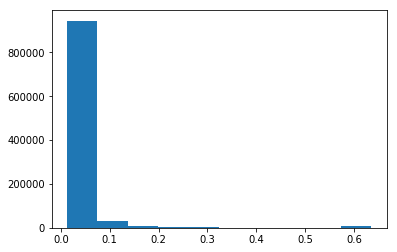

In [86]:
plt.hist(transformed_df["calibrated_prediction"])

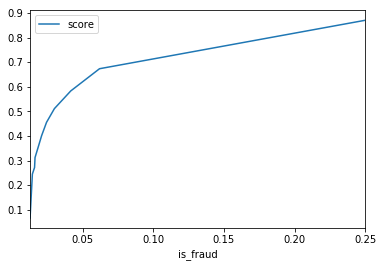

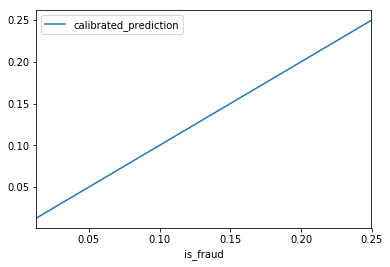

In [87]:
(transformed_df.assign(percentiles = pd.qcut(transformed_df["calibrated_prediction"], q= 20, duplicates="drop"))
.groupby("percentiles").agg({target_col: "mean", prediction_col: "mean"})).plot(x=target_col, y=prediction_col)
(transformed_df.assign(percentiles = pd.qcut(transformed_df["calibrated_prediction"], q= 20, duplicates="drop"))
.groupby("percentiles").agg({target_col: "mean", prediction_col: "mean", "calibrated_prediction": "mean"})).plot(x=target_col, y="calibrated_prediction")

### Gerando o ponto otimo da curva de otimização

In [88]:
# blocked = -review_fraud_cost
# not blocked = (1 - p) * amount * interchange - (p * new_card_cost + p * amount + p * review_fraud_cost)
# blocked = not_blocked (break_even probability)
# -p * (new_card_cost + amount * (1 + interchange) + review_fraud_cost) = -review_fraud_cost - amount * interchange
# p = (review_fraud_cost + amount * interchange) / (new_card_cost + amount + review_fraud_cost + amount * interchange)
transaction_amounts = np.arange(10, 20000, 10)
break_even_p = []
for amount in transaction_amounts:
    break_even_p.append((amount * interchange_revenue + review_fraud_cost)/ 
                        (new_card_cost + amount * (1 + interchange_revenue) + review_fraud_cost))
    
    
breakeven_df = pd.DataFrame(
    {amount_col: transaction_amounts,
    "threshold": break_even_p}
)

breakeven_df.head(50)

,amount,threshold
0,10,0.367946
1,20,0.256966
2,30,0.199058
3,40,0.163498
4,50,0.139442
5,60,0.122085
6,70,0.108970
7,80,0.098712
8,90,0.090469
9,100,0.083700


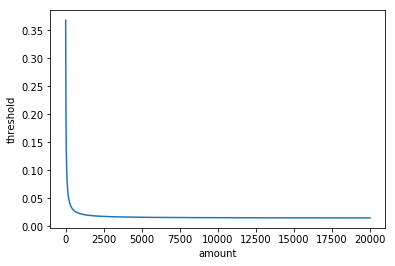

In [89]:
sns.lineplot(breakeven_df[amount_col], breakeven_df.threshold)

### Calculando a lucratividade dessa otimização

In [104]:
otimization_df = (transformed_df
      .assign(amount=lambda df: np.floor(df[amount_col] / 10) * 10)
      .merge(breakeven_df, on=amount_col, how="left")
      .assign(blocked=lambda df: df.calibrated_prediction > df.threshold))
optimized_decision = profit_from_decision(otimization_df)
optimized_decision

operational_cost    5.225440e+05
card_cost           5.926400e+04
fraud_losses        7.119550e+06
revenues            1.570276e+06
profit             -6.131082e+06
dtype: float64

## Criando bandas de modelo

### Bandas de mesma largura

In [93]:
band_size = 0.1
binned_df = df.assign(prediction_band = lambda df: np.floor(df[prediction_col] / band_size))
binned_df

,amount,international_purchase,is_fraud,score,prediction_band
0,291.899285,0,0,0.264879,2.0
1,29.372090,0,0,0.183100,1.0
2,153.462670,0,0,0.117238,1.0
3,471.391548,0,0,0.163781,1.0
4,17.260943,0,0,0.312624,3.0
5,38.895820,0,0,0.291718,2.0
6,62.400743,0,0,0.187849,1.0
7,2.941405,0,0,0.000000,0.0
8,58.097295,0,0,0.474347,4.0
9,375.249275,0,1,0.000000,0.0


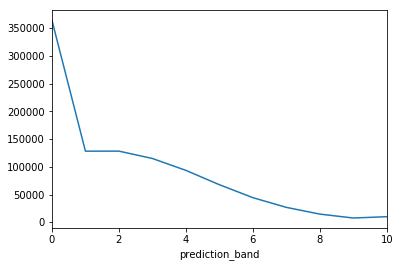

In [94]:
binned_df.groupby("prediction_band").count().amount.plot()

### Bandas de mesma quantidade de clientes

In [95]:
## This function is not "learning" how to band and we can't apply the same rule to new clients
number_of_bands = 10
banded_df = df.assign(bands= lambda df: pd.qcut(df[prediction_col], number_of_bands, duplicates="drop", retbins=False))

In [96]:
banded_df.bands.value_counts()

(-0.001, 0.0463]    300000
(0.606, 1.0]        100000
(0.466, 0.606]      100000
(0.367, 0.466]      100000
(0.283, 0.367]      100000
(0.206, 0.283]      100000
(0.129, 0.206]      100000
(0.0463, 0.129]     100000
Name: bands, dtype: int64

In [97]:
from fklearn.training.transformation import discrete_ecdfer

In [106]:
predict_fn, uniform_df, _ = discrete_ecdfer(df, 
                                            prediction_column=prediction_col, 
                                            max_range=1000)
uniform_df.head()

,amount,international_purchase,is_fraud,score,prediction_ecdf
0,291.899285,0,0,0.264879,576
1,29.372090,0,0,0.183100,470
2,153.462670,0,0,0.117238,385
3,471.391548,0,0,0.163781,445
4,17.260943,0,0,0.312624,635


In [107]:
## predict_fn "learns" how to apply the transformation and can be reapplied to any dataframe
predict_fn(uniform_df).head()

,amount,international_purchase,is_fraud,score,prediction_ecdf
0,291.899285,0,0,0.264879,576
1,29.372090,0,0,0.183100,470
2,153.462670,0,0,0.117238,385
3,471.391548,0,0,0.163781,445
4,17.260943,0,0,0.312624,635


(array([324000.,  75000.,  74999.,  75000.,  75000.,  76000.,  75000.,
         75000.,  75001.,  75000.]),
 array([ 248. ,  323.2,  398.4,  473.6,  548.8,  624. ,  699.2,  774.4,
         849.6,  924.8, 1000. ]),
 <a list of 10 Patch objects>)

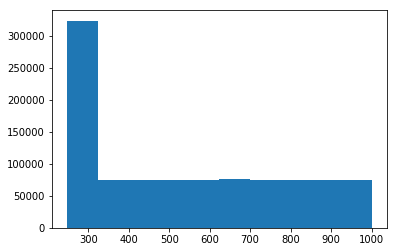

In [109]:
plt.hist(uniform_df["prediction_ecdf"])

### Regra baseada em grupos pre definidos
Apesar da regra ser muito simples, conseguimos uma performance quase tao boa quanto usando as probabilidades do modelo

In [101]:
groups_df = profit_from_decision(transformed_df.assign(blocked=lambda df: 
                      np.where(df.calibrated_prediction < 0.1, 0, 
                               np.where((df.calibrated_prediction >= 0.1) & (df.calibrated_prediction < 0.3) & (df[amount_col] < 100), 0, 1))
))
groups_df

operational_cost    3.220560e+05
card_cost           8.085200e+04
fraud_losses        1.277632e+07
revenues           -2.515634e+06
profit             -1.569486e+07
dtype: float64

## Regras de Negócio

In [102]:
otimization_df_with_rules = profit_from_decision(transformed_df
                  .assign(amount=lambda df: np.floor(df[amount_col] / 10) * 10)
                  .merge(breakeven_df, on=amount_col, how="left")
                  .assign(blocked=lambda df: df.calibrated_prediction > df.threshold)
                  .assign(blocked=lambda df: (df.blocked) | (df[amount_col] > 1000)))

otimization_df_with_rules

operational_cost    6.000480e+05
card_cost           5.241200e+04
fraud_losses        3.423170e+06
revenues            1.314689e+06
profit             -2.760941e+06
dtype: float64

/Users/henriquelopes/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


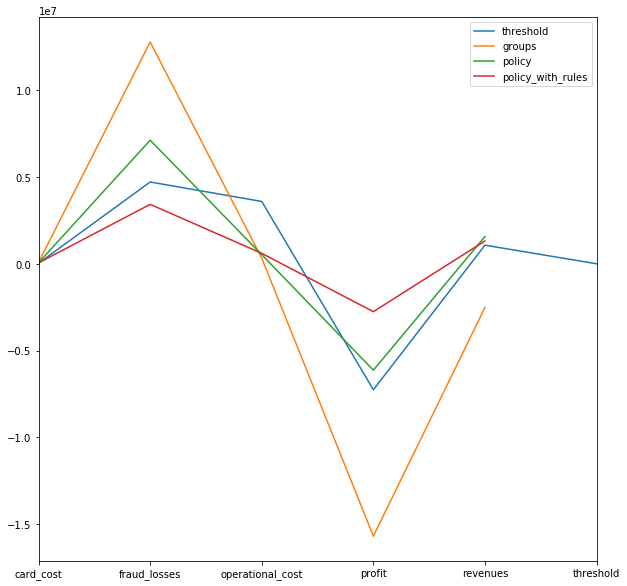

In [105]:
threshold_evaluation = (pd.concat([best_decision, groups_df, optimized_decision, otimization_df_with_rules],
                                 axis=1,
                                 keys=["threshold", "groups", "policy", "policy_with_rules"]))

fig, ax = plt.subplots(figsize=(10, 10))
threshold_evaluation.plot(ax=ax)